# Metabolic crosstalk on the 10x Visium mouse colon dataset

In this tutorial, we demonstrate how we can use Harreman to perform metabolic crosstalk both at the cell-type-agnostic and cell-type-specific levels. For this, we will build on the [metabolic zonation tutorial](https://harreman.readthedocs.io/en/latest/tutorials/notebooks/Visium_colon_metabolic_zonation.html) to infer metabolite exchange events that are specific to the previously defined zones.

If you are unfamiliar with how Harreman can be used to delineate metabolic zones in the tissue, we recommend starting with the [metabolic zonation tutorial](https://harreman.readthedocs.io/en/latest/tutorials/notebooks/Visium_colon_metabolic_zonation.html). However, most of the functions that we will cover in this tutorial do not depend on the outputs generated in the previous tutorial. Therefore, if you are not interested in dividing the tissue into metabolic zones, the previous tutorial can be skipped. In this case, beware of the functions that make use of metabolic modules, as you won't be able to successfully run them until the metabolic zonation results are stored in your AnnData.

Plan for this tutorial:

1. Loading the data.
2. Inferring cell-type-agnostic gene pair and metabolite crosstalk.
3. Computing interacting gene pair and metabolite scores.
4. Group spatially co-localized metabolites.
5. Perform differential metabolite abundance analysis between the inflamed and healthy samples.
6. Correlation between metabolite group scores and metabolic module scores.

## Loading the dataset

In this tutorial, we will work with the AnnData saved in the [metabolic zonation tutorial](https://harreman.readthedocs.io/en/latest/tutorials/notebooks/Visium_colon_metabolic_zonation.html).

In [2]:
import harreman
import os
import tempfile
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import itertools
import mplscience
from scipy.stats import pearsonr, wilcoxon, mannwhitneyu, spearmanr
import random
import scipy.stats as stats
from sklearn import linear_model
from scipy.stats import hypergeom, zscore, norm
from statsmodels.stats.multitest import multipletests
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
adata = harreman.read_h5ad('Visium_colon_metabolic_zonation.h5ad')

## Cell-type-agnostic metabolic crosstalk

Firstly, we extract the metabolite and ligand-receptor interaction information for cellular crosstalk inference using the `extract_interaction_db` function. For this, we need to specify the organism the dataset corresponds to (with the `species` parameter), indicate if we want to load only transporter information from HarremanDB (`database='transporter'`), only ligand-receptor information from CellChatDB (`database='LR'`), or both of them (`database='both'`). In case we don't want to restrict the interactions to the extracellular space, we can use the `extracellular_only` parameter with the `False` value.

Here, we load both databases from mouse and we restrict the interactions to the extracellular space.

In [4]:
harreman.pp.extract_interaction_db(adata, species='mouse', database='both', verbose=True)

Extracting interaction database...
Finished extracting interaction database in 17.192 seconds


We then compute the neighborhood graph using the `compute_knn_graph` function. For this, we need to specify the latent (or observed) space we are using to compute our cell metric with the `compute_neighbors_on_key` parameter. Further, only one of `compute_neighbors_on_key` or `distances_obsp_key` is needed in order to run the function. Similarly, either the `neighborhood_radius` or the `n_neighbors` parameter needs to be used (the former needs to contain information in micrometers). The `sample_key` parameter is optional and is only required when more than one sample are present in the AnnData and we want to avoid having neighbors across different samples.

Here, we set `weighted_graph=False` to just use binary, 0-1 weights and `n_neighbors=5` to create a local neighborhood in the unrolled tissue space with the 5 nearest neighbors for every spot. Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale, spatial patterns. Further, we set `sample_key='cond'` to make sure there are no shared neighbors between samples. Note that the neighbors are computed in the unrolled tissue space and not in the original coordinates. This is because the unrolled coordinates preserve *in vivo* spatial relationships more faithfully than the histological Swiss roll.

In [5]:
harreman.tl.compute_knn_graph(adata, 
                        compute_neighbors_on_key="spatial_unrolled", 
                        n_neighbors=5,
                        weighted_graph=False,
                        sample_key='cond',
                        verbose=True)

Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 98.97it/s]

Computing the weights...
Finished computing the KNN graph in 0.045 seconds


Once the neighborhood graph is computed, genes can be filtered out to restrict the interactions to the most informative ones using the `apply_gene_filtering` function. For this, several options have been implemented. In our case, we use local autocorrelation (`autocorrelation_filt = True` parameter) with the negative binomial distribution to model our data.

In [6]:
harreman.tl.apply_gene_filtering(adata, layer_key='counts', model='danb', autocorrelation_filt = True, verbose=True)

Applying gene filtering...
Computing local autocorrelation...
Local autocorrelation results are stored in adata.uns['gene_autocorrelation_results']
Finished computing local autocorrelation in 1.487 seconds
Finished applying gene filtering in 1.488 seconds


To compute gene pairs, the `compute_gene_pairs` function is used. For this, cell type information can be used to compute cell-type-specific pairs. Here, as we are inferring crosstalk in a cell-type-agnostic way, `ct_specific = False` will be specified.

In [7]:
harreman.tl.compute_gene_pairs(adata, ct_specific = False, verbose=True)

Computing gene pairs...
Finished computing gene pairs in 1.838 seconds


To infer metabolic crosstalk, the `compute_cell_communication` function is used. To assess statistical significance, we can either use the parametric test (`test = "parametric"`), the non-parametric one (`test = "non-parametric"`), or both of them (`test = "both"`). If the parametric test needs to be computed, the `model` parameter needs to be specified, in addition to the raw counts layer (`layer_key_p_test` parameter). In this case, we use the negative binomial distribution to model the count data. In case the non-parametric test is used, the number of permutations is specified through the `M` parameter (1000 by default), as well as the layer of the raw or normalized count data (`layer_key_np_test` parameter). In our case, we use the log-normalized counts to infer crosstalk and assess its significance through the non-parametric test.

In [9]:
harreman.tl.compute_cell_communication(adata, model='danb', M = 1000, test = "both", layer_key_p_test='counts', layer_key_np_test='log_norm', verbose=True)

Starting cell-cell communication analysis...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s]


Non-parametric test finished.
Obtaining communication results...
Finished computing cell-cell communication analysis in 39.149 seconds


We then select statistically significant interactions (FDR < 0.05) from the non-parametric test (specified in the `test` parameter).

In [10]:
harreman.tl.select_significant_interactions(adata, test = "non-parametric", threshold = 0.05)

### Computing gene pair and metabolite interacting scores

To visualize the interactions at the gene pair and metabolite levels in the tissue, the `compute_interacting_cell_scores` is used. The `test` parameter is analogous to the `compute_cell_communication` function, but, instead of using it to compute statistical significance (for this only the non-parametric test is used), we use it to specify if we want to compute the values using the raw counts (used for the parametric test) or the log-normalized counts (used for the non-parametric test). Here, we consider both of them, but we will eventually focus on the scores computed using the log-normalized counts.

In [11]:
harreman.tl.compute_interacting_cell_scores(adata, test = "both", verbose=True, device='cpu')

Computing gene pair and metabolite scores...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


Non-parametric test finished.
Finished computing gene pair and metabolite scores in 432.758 seconds


We then compute the correlation between the metabolite (or gene pair) scores and the metabolic module scores defined in the [metabolic zonation tutorial](https://harreman.readthedocs.io/en/latest/tutorials/notebooks/Visium_colon_metabolic_zonation.html). For this, the metabolite (or gene pair) scores computed in the non-parametric test (using the log-normalized counts) are considered. To specify whether we want to focus on gene pair or metabolite scores, the `interaction_type` parameter is used (with the `metabolite` or `gene_pair` value). Here, we run the function at the metabolite level.

In [12]:
harreman.tl.compute_interaction_module_correlation(adata, cor_method='pearson', use_super_modules=True, interaction_type='metabolite', test='non-parametric')

### Downstream analyses

We then visualize the correlation between metabolite scores and module scores.

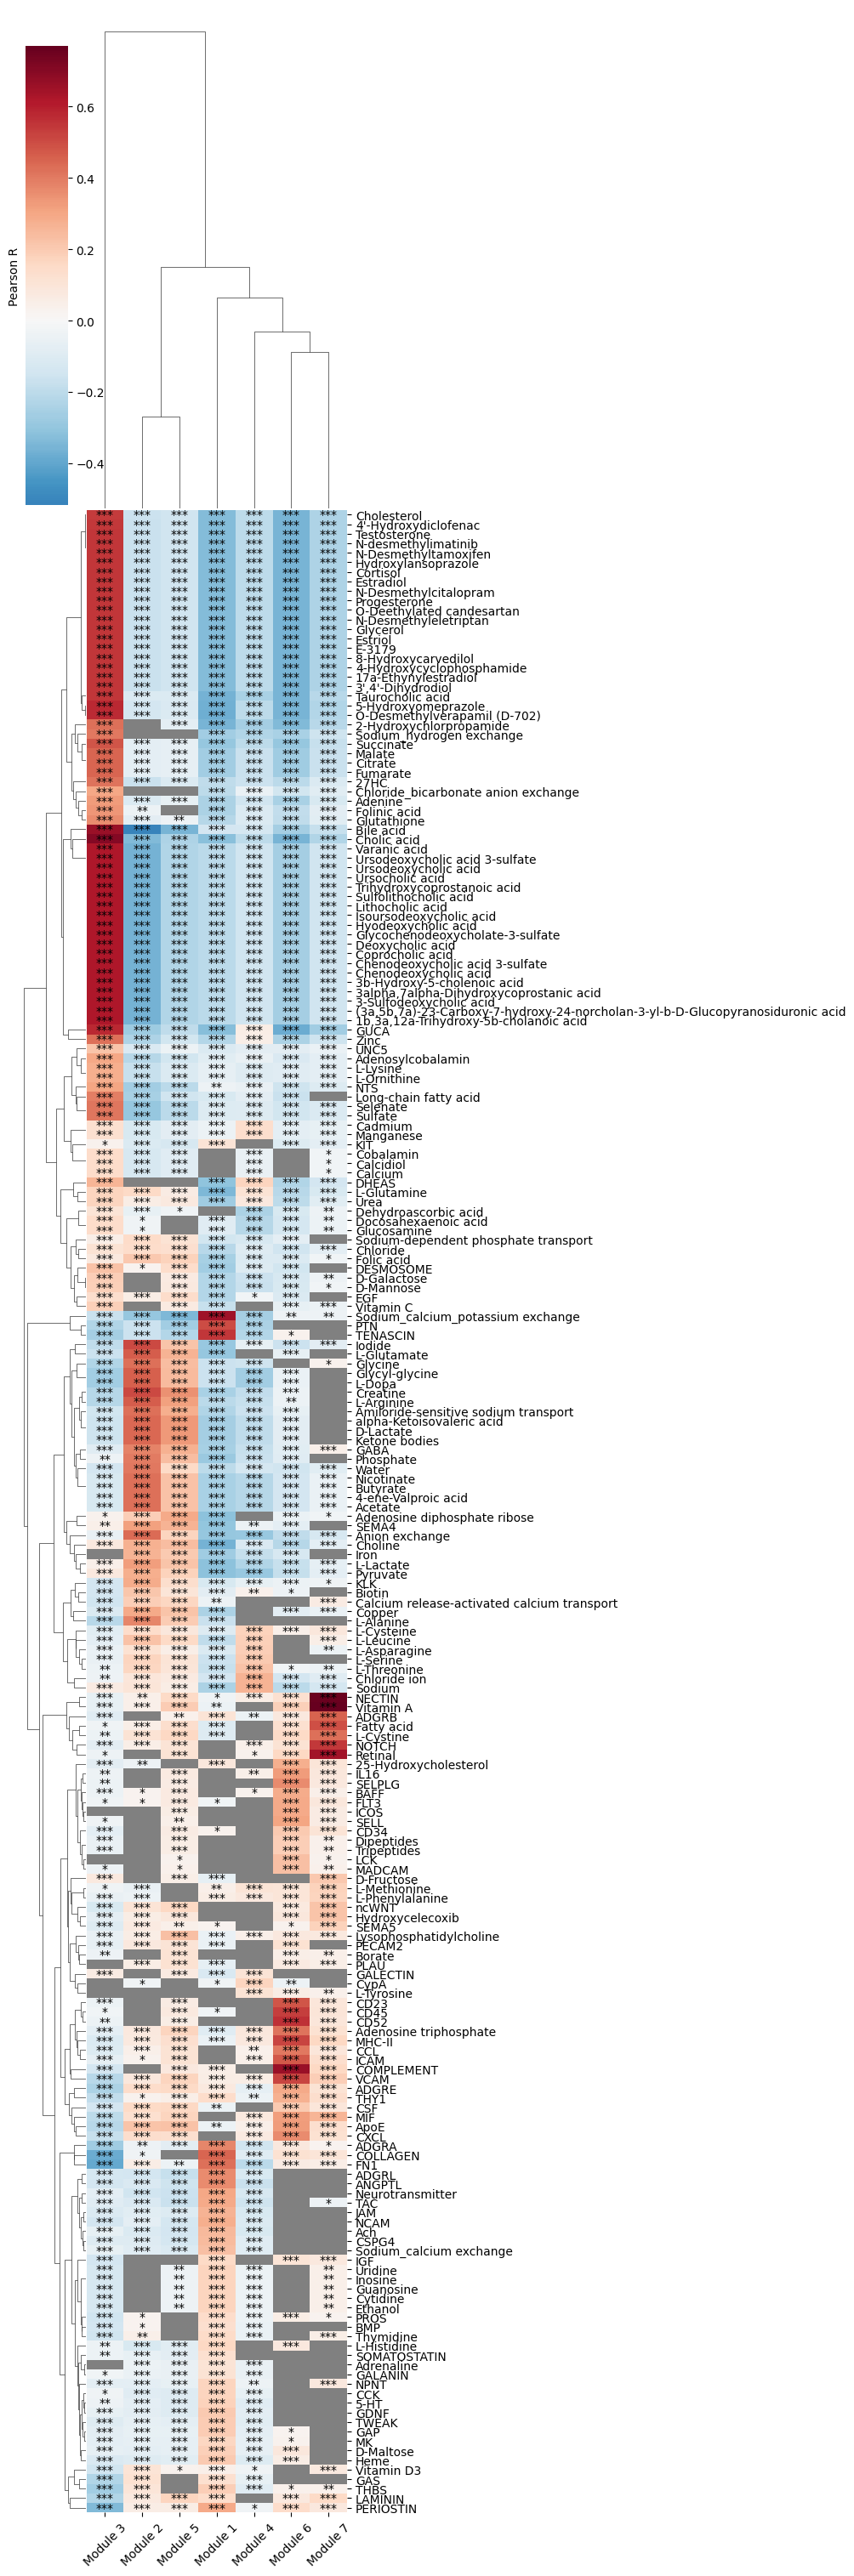

In [13]:
harreman.pl.plot_interaction_module_correlation(adata, x_rotation = 45, figsize = (10,30), threshold = 0.1)

We select some metabolites to visualize them in the tissue.

In [14]:
metabolites = ['Sodium_calcium_potassium exchange', 'Creatine', 'Cholic acid', 'Adenosine triphosphate', 'Vitamin A', 'Lysophosphatidylcholine']

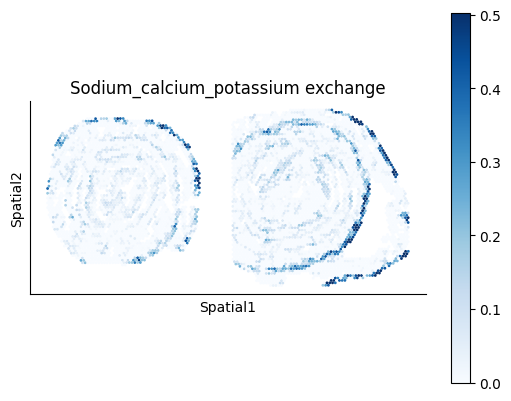

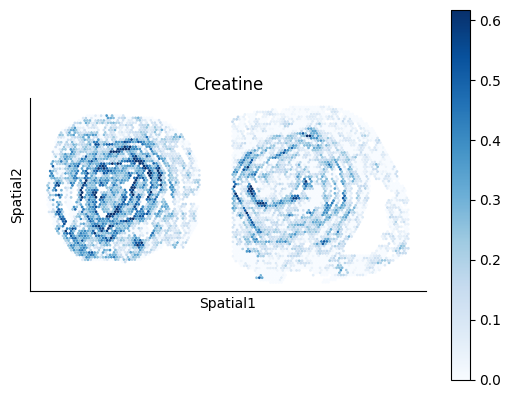

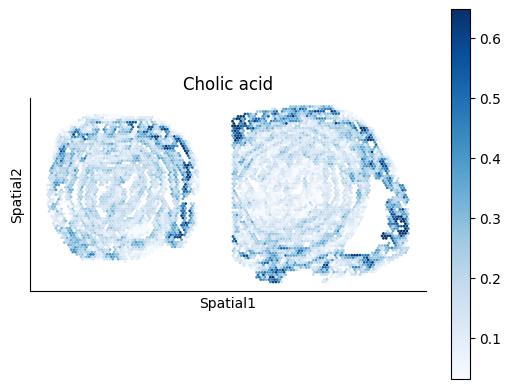

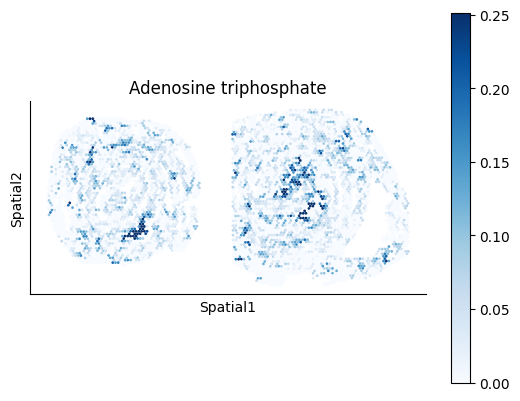

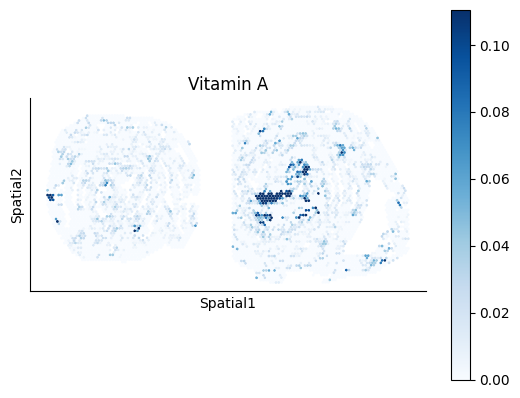

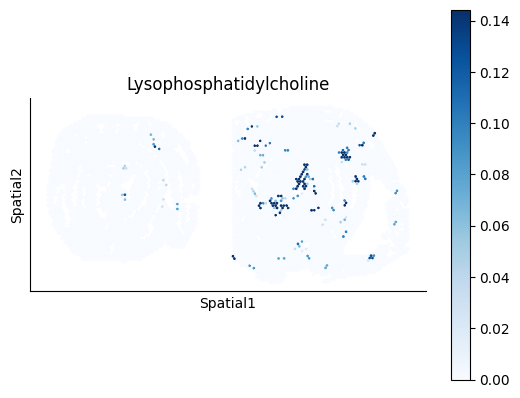

In [15]:
harreman.pl.plot_interacting_cell_scores(adata, interactions=metabolites, test='non-parametric', coords_obsm_key='spatial', s=1, vmin='p5', vmax='p99', only_sig_values=False, normalize_values=True, cmap='Blues', swap_y_axis=True)

We can also visualize the distribution of the metabolite scores of these metabolites across the metabolic modules defined previously.

In [16]:
interacting_cell_scores_gp = adata.uns['interacting_cell_results']['np']['gp']['cs']
interacting_cell_scores_m = adata.uns['interacting_cell_results']['np']['m']['cs']

interacting_cell_scores_gp = pd.DataFrame(interacting_cell_scores_gp, index=adata.obs_names, columns=adata.uns['gene_pairs_sig_names'])
interacting_cell_scores_m = pd.DataFrame(interacting_cell_scores_m, index=adata.obs_names, columns=adata.uns['metabolites'])
gene_pairs = [inter for inter in metabolites if inter in adata.uns['gene_pairs_sig_names']]
metabs = [inter for inter in metabolites if inter in adata.uns['metabolites']]
if len(gene_pairs) > 0 and len(metabs) > 0:
    interacting_cell_scores = pd.concat([interacting_cell_scores_gp, interacting_cell_scores_m], axis=1)
elif len(gene_pairs) == 0 and len(metabs) == 0:
    raise ValueError("The provided LR pairs and/or metabolites don't have significant interactions.")
else:
    interacting_cell_scores = interacting_cell_scores_gp if len(gene_pairs) > 0 else interacting_cell_scores_m

scores = interacting_cell_scores[metabolites]
scores = scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [17]:
violin_data = pd.concat([scores, adata.obs[['cond', 'top_super_module']]], axis=1).dropna()

In [18]:
violin_data_melt = pd.melt(violin_data, id_vars=['cond', 'top_super_module'], value_vars=metabolites)

In [19]:
cond_palette = {
    'Day 0': '#ffbb78',
    'Day 14': '#c5b0d5',
}

In [20]:
violin_data_melt['cond'] = violin_data_melt['cond'].astype('category')
violin_data_melt['variable'] = violin_data_melt['variable'].astype('category')

In [21]:
violin_data_melt['variable'] = violin_data_melt['variable'].astype('category')
violin_data_melt['variable'] = violin_data_melt['variable'].cat.reorder_categories(metabolites)

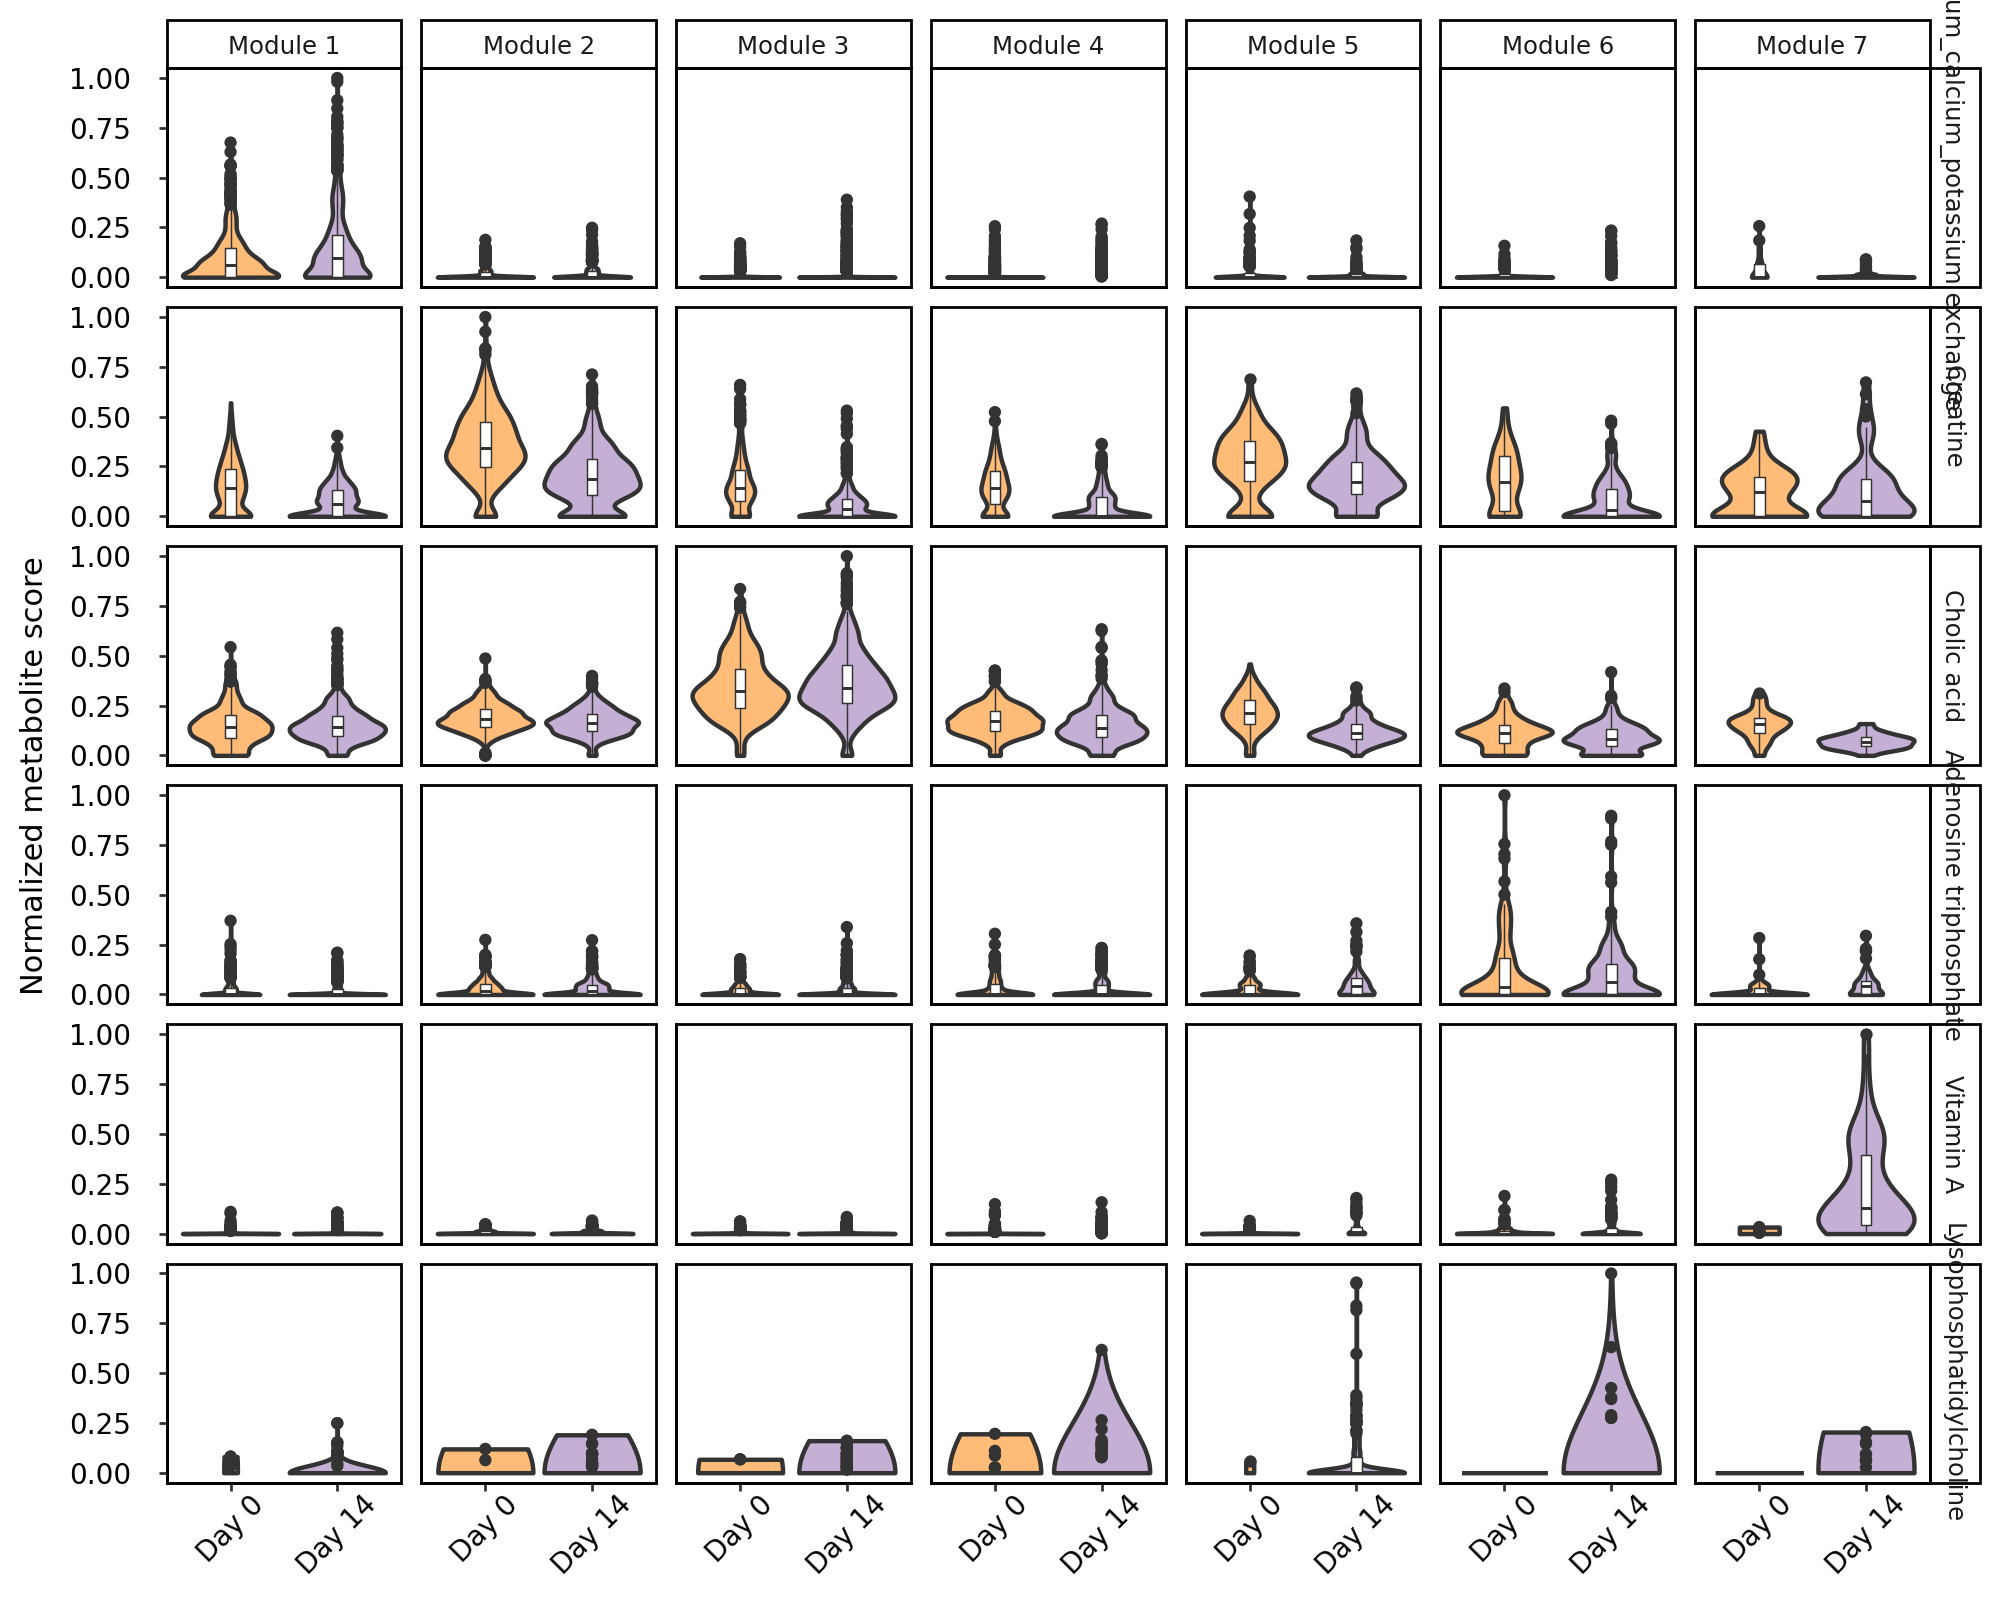

In [22]:
fig = (
ggplot(data=violin_data_melt, mapping=aes(x='cond', y='value', fill='cond')) 
+ geom_violin(size=0.9)
+ geom_boxplot(width=0.1, fill='white', size=0.3)
+ facet_grid(rows='variable', cols='top_super_module')
+ scale_fill_manual(values=cond_palette)
# + xlab('')
+ ylab('Normalized metabolite score')
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_blank(),
        axis_title_y = element_text(size = 11),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 10, colour='black', rotation=45),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 10, colour='black'),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(10, 8))
)
fig.show()

We can also identify which gene pairs belonging to the metabolites of interest have a significant spatial co-expression.

In [23]:
cell_communication_df = adata.uns['ccc_results']['cell_com_df_gp_sig'].copy()

In [26]:
gene_pairs_per_metabolite = adata.uns['gene_pairs_per_metabolite']
    
def to_tuple(x):
    # Recursively convert lists to tuples
    if isinstance(x, list):
        return tuple(to_tuple(i) for i in x)
    return x

metabolite_gene_pair_df = pd.DataFrame.from_dict(gene_pairs_per_metabolite, orient="index").reset_index()
metabolite_gene_pair_df = metabolite_gene_pair_df.rename(columns={"index": "metabolite"})
metabolite_gene_pair_df['gene_pair'] = metabolite_gene_pair_df['gene_pair'].apply(
    lambda arr: [(to_tuple(gp[0]), to_tuple(gp[1])) for gp in arr]
)
metabolite_gene_pair_df['gene_type'] = metabolite_gene_pair_df['gene_type'].apply(
    lambda arr: [(to_tuple(gt[0]), to_tuple(gt[1])) for gt in arr]
)
metabolite_gene_pair_df = pd.concat([
    metabolite_gene_pair_df['metabolite'],
    metabolite_gene_pair_df.explode('gene_pair')['gene_pair'],
    metabolite_gene_pair_df.explode('gene_type')['gene_type'],
], axis=1).reset_index(drop=True)

if 'LR_database' in adata.uns:
    LR_database = adata.uns['LR_database']
    df_merged = pd.merge(metabolite_gene_pair_df, LR_database, left_on='metabolite', right_on='interaction_name', how='left')
    LR_df = df_merged.dropna(subset=['pathway_name'])
    metabolite_gene_pair_df['metabolite'][metabolite_gene_pair_df.metabolite.isin(LR_df.metabolite)] = LR_df['pathway_name']

In [27]:
metabolite_gene_pair_df = metabolite_gene_pair_df.set_index('metabolite')

In [28]:
def is_present(row, gene_pairs):
    gene1, gene2 = row['Gene 1'], row['Gene 2']
    return any(
        (gene1 in pair and gene2 in pair) if isinstance(pair, tuple) else False
        for pair in gene_pairs
    )

gene_pairs = metabolite_gene_pair_df.loc[metabolites]['gene_pair'].tolist()
cell_communication_df_filt = cell_communication_df[cell_communication_df.apply(lambda row: is_present(row, gene_pairs), axis=1)]

In [29]:
gene_pairs_filt = list(zip(cell_communication_df_filt["Gene 1"], cell_communication_df_filt["Gene 2"]))

In [30]:
gene_1 = ["_".join(pair[0]) if isinstance(pair[0], list) else pair[0] for pair in gene_pairs]
gene_2 = ["_".join(pair[1]) if isinstance(pair[1], list) else pair[1] for pair in gene_pairs]

def remove_duplicates(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

gene_1 = remove_duplicates(gene_1)
gene_2 = remove_duplicates(gene_2)

In [31]:
cell_communication_df_filt['log10_FDR'] = -np.log10(cell_communication_df_filt['FDR_np'])
cell_communication_df_filt['log10_C'] = np.log10(cell_communication_df_filt['C_np'])

In [32]:
def convert_list_to_string(value):
    return '_'.join(value) if isinstance(value, list) else value

# Apply conversion to both columns
cell_communication_df_filt['Gene 1'] = cell_communication_df_filt['Gene 1'].apply(convert_list_to_string)
cell_communication_df_filt['Gene 2'] = cell_communication_df_filt['Gene 2'].apply(convert_list_to_string)

In [33]:
gene_1 = [gene for gene in gene_1 if gene in cell_communication_df_filt['Gene 1'].unique()]
gene_2 = [gene for gene in gene_2 if gene in cell_communication_df_filt['Gene 2'].unique()]

In [34]:
cell_communication_df_filt['Gene 1'] = cell_communication_df_filt['Gene 1'].astype('category')
cell_communication_df_filt['Gene 1'] = cell_communication_df_filt['Gene 1'].cat.reorder_categories(gene_1[::-1])

cell_communication_df_filt['Gene 2'] = cell_communication_df_filt['Gene 2'].astype('category')
cell_communication_df_filt['Gene 2'] = cell_communication_df_filt['Gene 2'].cat.reorder_categories(gene_2)

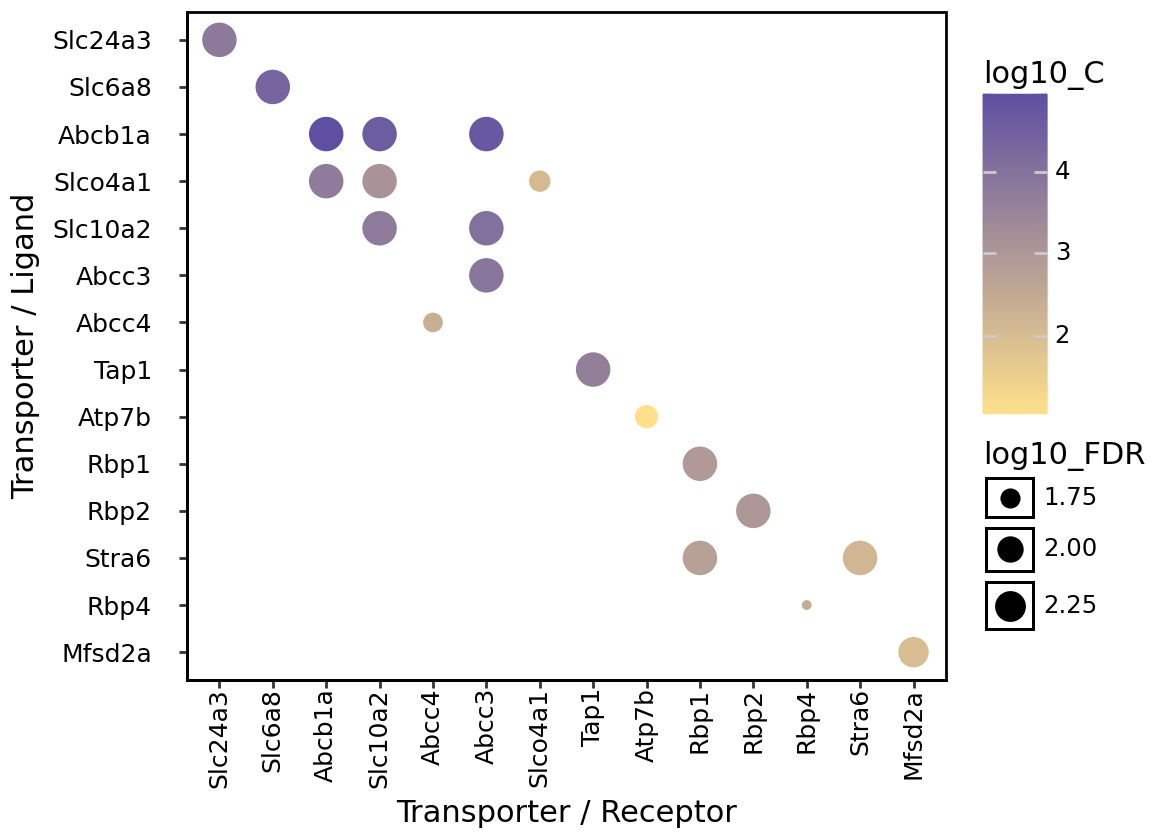

In [35]:
fig = (
ggplot(data=cell_communication_df_filt, mapping=aes(x='Gene 2', y='Gene 1', color='log10_C', size='log10_FDR')) 
+ geom_point()
+ scale_color_gradient(low = "#FEE08B", high = "#5E4FA2")
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        # legend_position = "none",
        axis_title_x = element_text(size = 11),
        axis_title_y = element_text(size = 11),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 9, colour='black', rotation=90),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 9, colour='black'),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(5.8, 4.2)) + ylab('Transporter / Ligand') + xlab('Transporter / Receptor')
)
fig.show()

### Group spatially co-localized metabolites

We now group spatially co-localized metabolites and assess if their presence is correlated with the predefined metabolic zones. For this, we will binarize the metabolite scores computed using the `compute_interacting_cell_scores` function, such that those spots with a value higher than 1 standard deviation above the mean will be assigned a value of 1, and 0 otherwise.

In [48]:
interacting_cell_scores_m = adata.uns['interacting_cell_results']['np']['m']['cs'].copy()
n=1
means = np.nanmean(interacting_cell_scores_m, axis=0)
stds = np.nanstd(interacting_cell_scores_m, axis=0)
thresholds = means + n*stds
interacting_cell_scores_m[interacting_cell_scores_m < thresholds] = 0

In [49]:
interacting_cell_scores_m = pd.DataFrame(interacting_cell_scores_m, index=adata.obs_names, columns=adata.uns['metabolites'])

In [50]:
interacting_cell_scores_m[interacting_cell_scores_m != 0] = 1

We create a new AnnData with the binarized metabolite scores to run the metabolic zonation pipeline.

In [51]:
metab_scores_adata = ad.AnnData(interacting_cell_scores_m)
metab_scores_adata.obs_names = adata.obs_names
metab_scores_adata.var_names = adata.uns['metabolites']

metab_scores_adata.obs['cond'] = adata.obs['cond']
metab_scores_adata.obsm['spatial_unrolled'] = adata.obsm['spatial_unrolled']
metab_scores_adata.obsm['spatial'] = adata.obsm['spatial']

Here we compute the spatial proximity graph using the same parameters as before.

In [52]:
harreman.tl.compute_knn_graph(metab_scores_adata, 
                           compute_neighbors_on_key="spatial_unrolled", 
                           n_neighbors=5,
                           weighted_graph=False,
                           sample_key='cond')

100%|██████████| 2/2 [00:00<00:00, 97.95it/s]


The code below is only run to filter out metabolites with all-zero values in at least one of the samples for subsequent pairwise correlation. We don't select autocorrelated metabolites through this approach as they have already been selected using the `select_significant_interactions` function.

Here, unlike in the metabolic zonation pipeline, the Bernoulli will be used, as the metabolite scores have been binarized and this is the best distribution to model the data.

In [53]:
harreman.hs.compute_local_autocorrelation(metab_scores_adata, model='bernoulli')

In [54]:
gene_autocorrelation_results = metab_scores_adata.uns['gene_autocorrelation_results']
metabolites = gene_autocorrelation_results.index

Pairwise correlation between binarized metabolite scores is also evaluated.

In [55]:
harreman.hs.compute_local_correlation(metab_scores_adata, genes=metabolites, verbose=True)

Computing pair-wise local correlation on 234 features...
Pair-wise local correlation results are stored in adata.uns with the following keys: ['lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 0.090 seconds


Then, metabolite groups are created.

In [56]:
harreman.hs.create_modules(metab_scores_adata, min_gene_threshold=9)

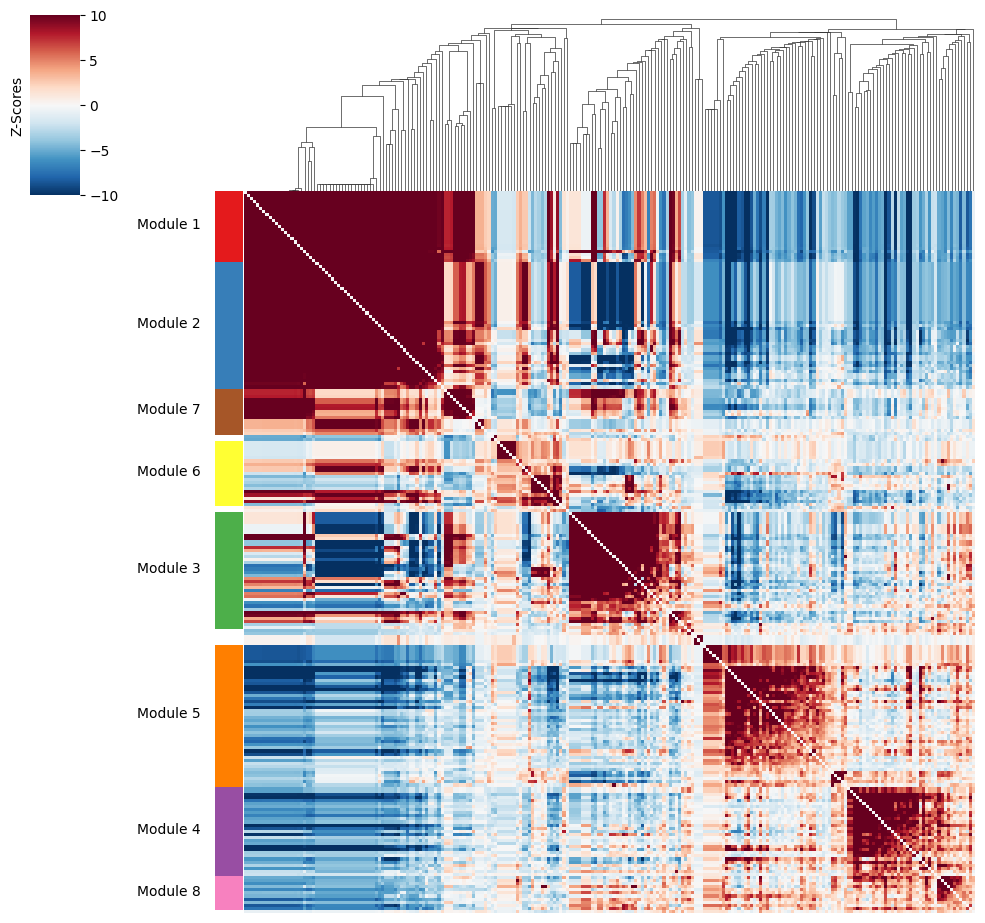

In [57]:
harreman.pl.local_correlation_plot(metab_scores_adata, mod_cmap='Set1')

We also compute metabolite group scores to eventually correlate them with the previously computed metabolic module scores.

In [58]:
harreman.hs.calculate_module_scores(metab_scores_adata)

100%|██████████| 8/8 [00:00<00:00, 16.69it/s]


In [66]:
modules = metab_scores_adata.obsm['module_scores'].columns
metab_scores_adata.obs[modules] = metab_scores_adata.obsm['module_scores']

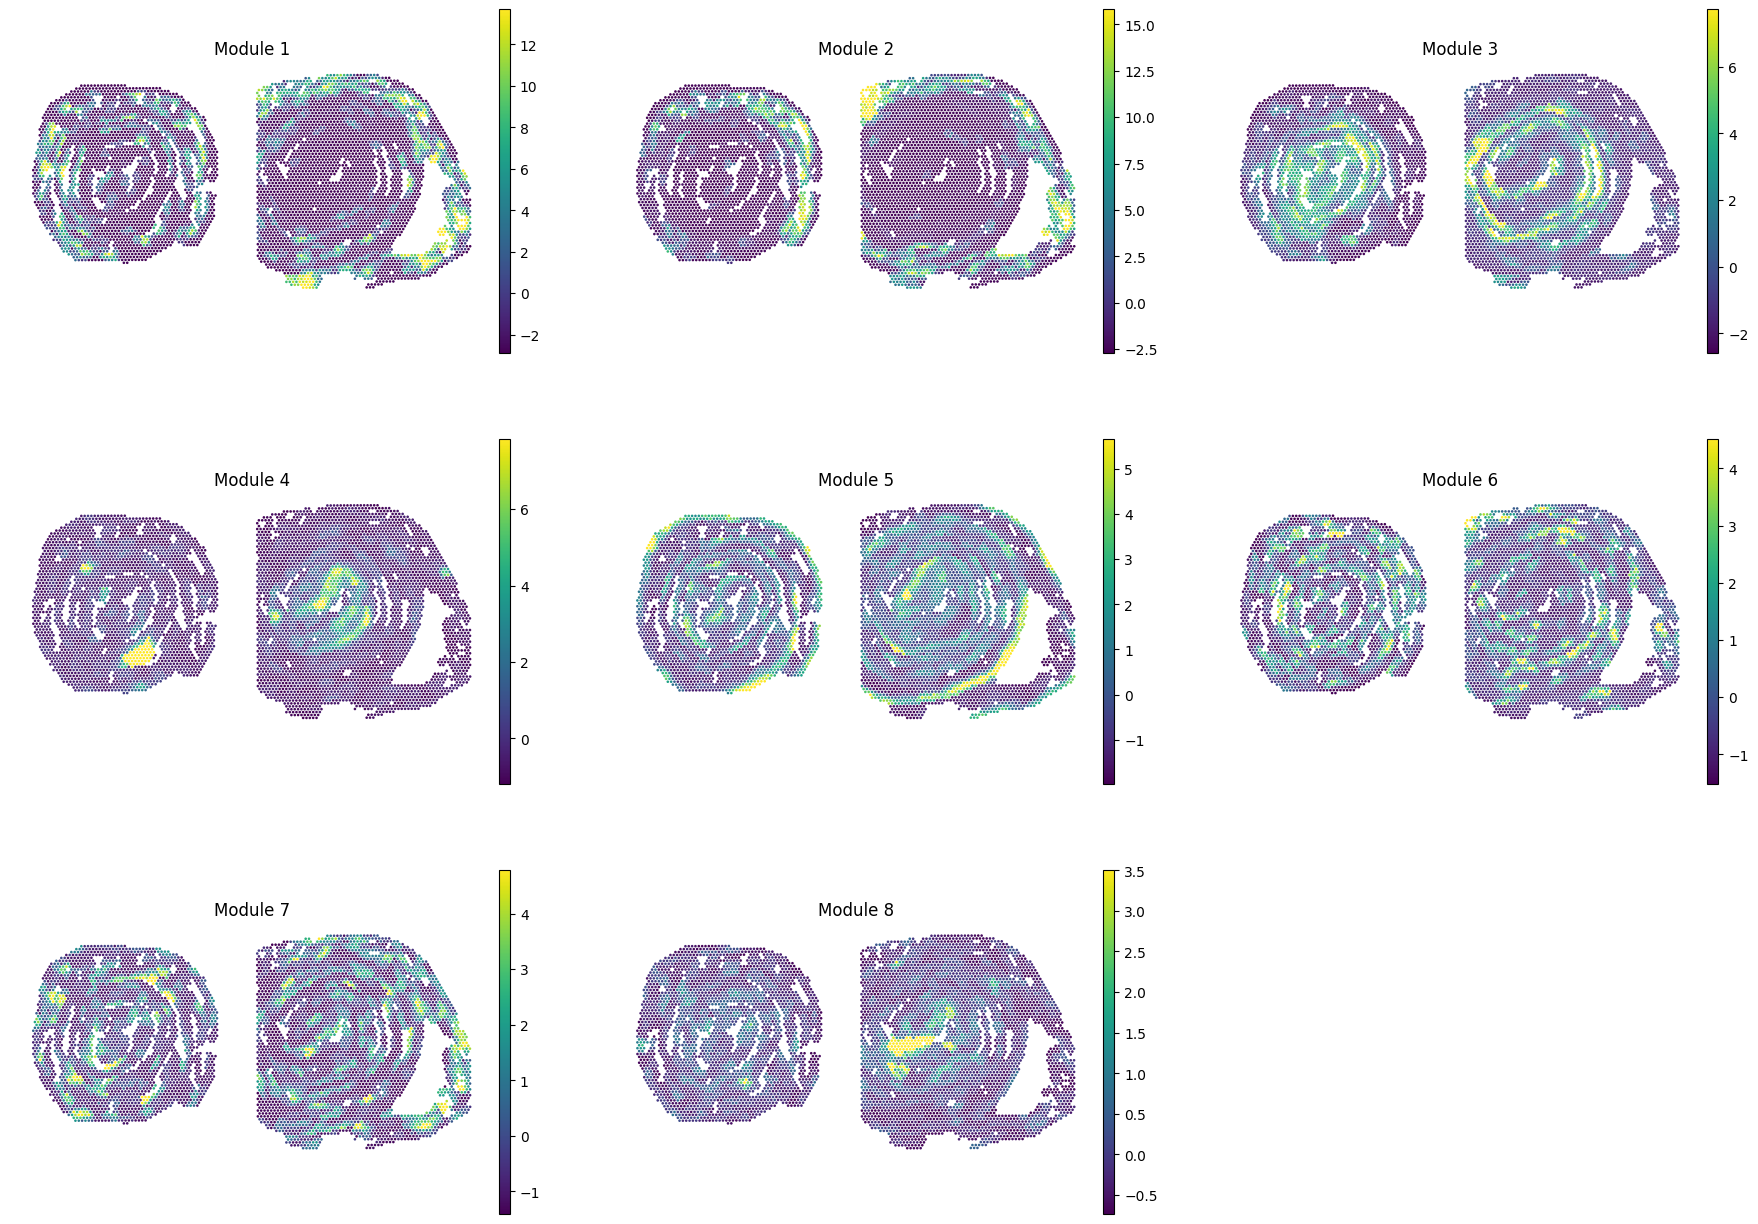

In [60]:
sc.pl.spatial(metab_scores_adata, color=modules, spot_size=80, frameon=False, vmin="p1", vmax="p99", ncols=3, cmap='viridis')

Eventually, metabolite modules can also be grouped together into super-groups and we recompute the scores using the same approach as in the metabolic zonation pipeline.

In [61]:
super_module_dict = {
    -1: [6],
    1: [1, 2, 7],
    2: [3],
    3: [4],
    4: [5],
    5: [8],
}

In [62]:
harreman.hs.calculate_super_module_scores(metab_scores_adata, super_module_dict=super_module_dict)

100%|██████████| 5/5 [00:00<00:00, 15.31it/s]

Finished computing super-module scores in 0.335 seconds


We can then visualize the pairwise correlation plot at the super-group level.

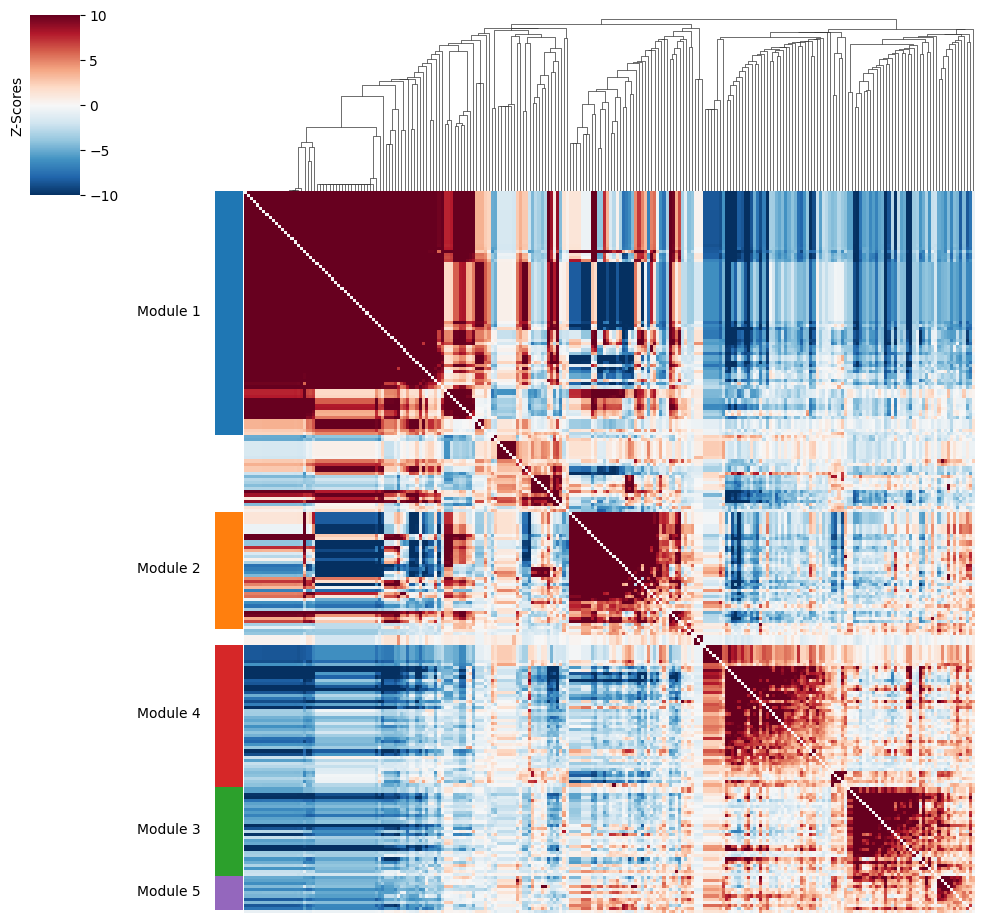

In [63]:
harreman.pl.local_correlation_plot(metab_scores_adata, use_super_modules=True, show=True)

And super-group scores are computed.

In [64]:
super_modules = metab_scores_adata.obsm['super_module_scores'].columns
metab_scores_adata.obs[super_modules] = metab_scores_adata.obsm['super_module_scores']

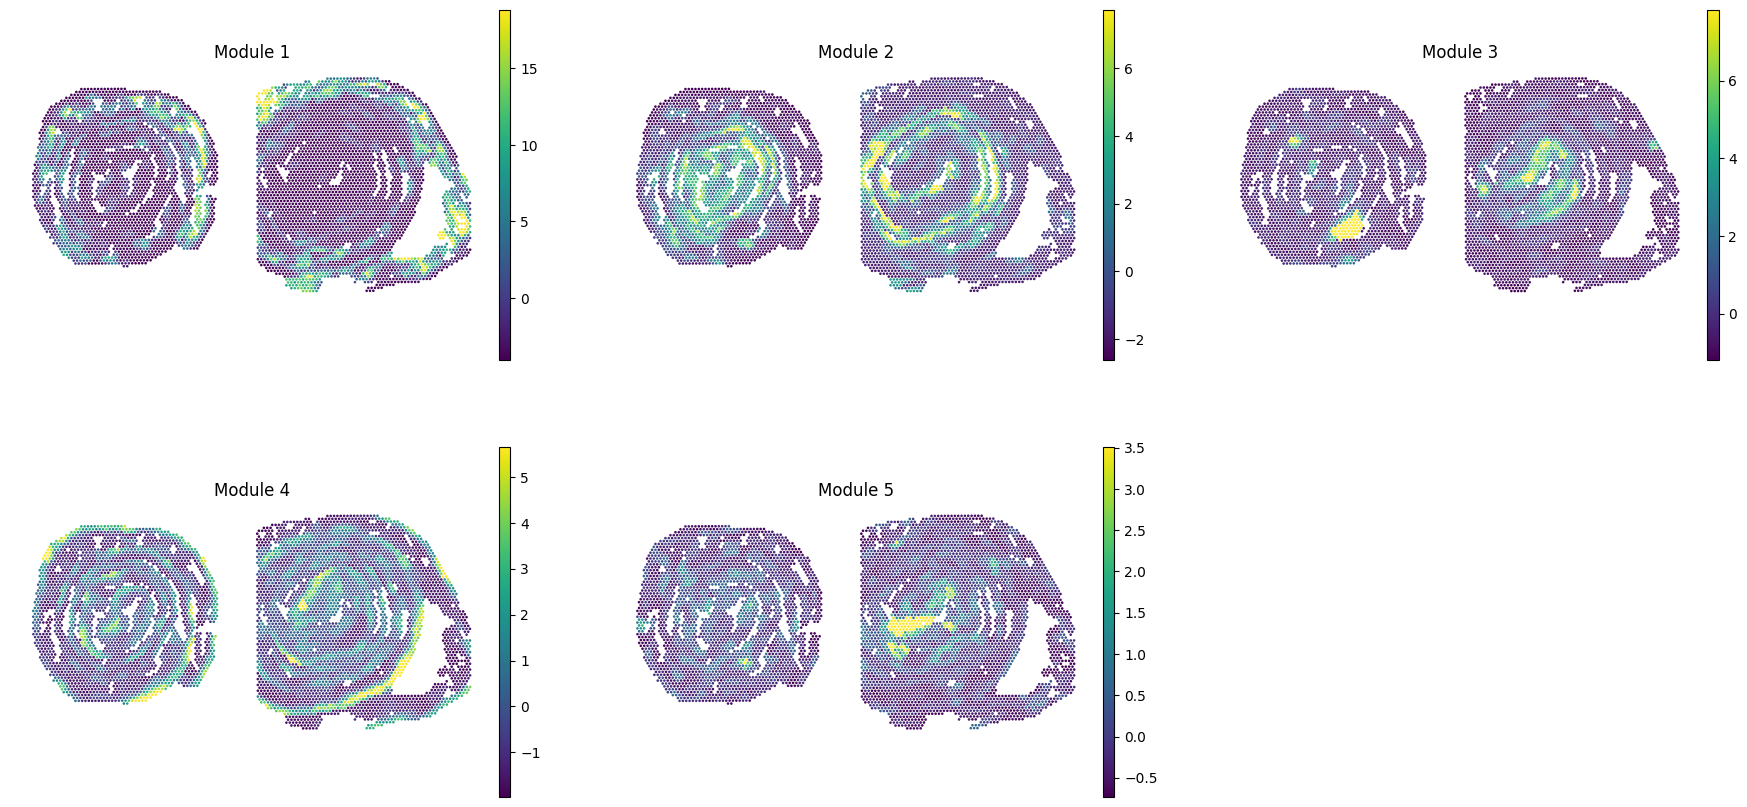

In [65]:
sc.pl.spatial(metab_scores_adata, color=super_modules, spot_size=80, frameon=False, vmin="p1", vmax="p99", ncols=3, cmap='viridis')

#### Module / metabolite group correlation analysis

We compute the correlation between metabolic module scores and metabolite group scores.

In [67]:
common_cells = adata.obsm['super_module_scores'].index.intersection(metab_scores_adata.obsm['super_module_scores'].index)
df1a = adata.obsm['super_module_scores'].loc[common_cells]
df2a = metab_scores_adata.obsm['super_module_scores'].loc[common_cells]

corr = pd.DataFrame(index=df1a.columns, columns=df2a.columns, dtype=float)
for m1 in df1a.columns:
    for m2 in df2a.columns:
        corr.at[m1, m2] = df1a[m1].corr(df2a[m2], method='spearman')

In [68]:
colors = list(plt.get_cmap('tab10').colors)
palette_m = {mod: colors[int(mod.split(' ')[1])-1] for mod in adata.obs['top_super_module'].dropna().unique()}

In [70]:
palette = {
    'Module -1': "#BDBDBD",
    'Module 1': "#FC9272",
    'Module 2': "#DFC27D",
    'Module 3': "#80CDC1",
    'Module 4': "#ABDDA4",
    'Module 5': "#F1B6DA",
}

And we then can visualize the correlation results.

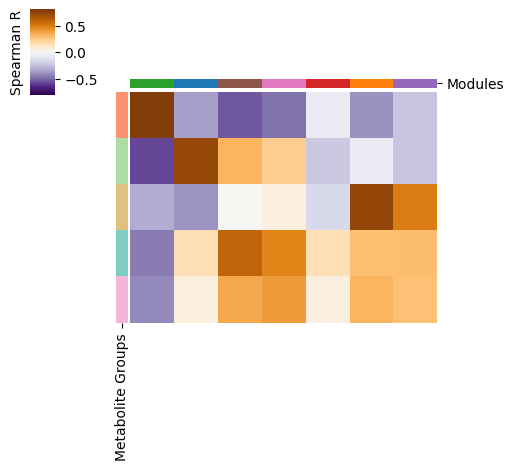

In [72]:
vmin=-0.8
vmax=0.8
cmap=sns.color_palette("PuOr_r", as_cmap=True)
yticklabels=False

row_colors1 = pd.Series(
    [palette_m[i] for i in corr.index],
    index=corr.index,
)

row_colors = pd.DataFrame({
    "Modules": row_colors1,
})

col_colors1 = pd.Series(
    [palette[i] for i in corr.columns],
    index=corr.columns,
)

col_colors = pd.DataFrame({
    "Metabolite Groups": col_colors1,
})

cm = sns.clustermap(
    corr.T,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=col_colors,
    col_colors=row_colors,
    rasterized=True,
    figsize=(5,4.75),
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()

plt.sca(cm.ax_row_colors)

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Spearman R')
min_aa.yaxis.set_label_position("left")

plt.show()

## Cell-type-specific metabolic crosstalk

In the final step of the Harreman pipeline, we will perform cell-type-specific metabolic crosstalk inference by focusing on a few metabolites of interest and their corresponding significant gene pairs.

To assign cell types to spots, we can do different things. On the one hand, if the dataset contains single cells instead of spots (not in this case), we could directly annotate the cells and then run the pipeline directly. On the other hand, we could run DestVI (Lopez et al., *Nature biotechnology*, 2022) or another cell type deconvolution algorithm (such as cell2location; Kleshchevnikov et al., *Nature biotechnology*, 2022) to infer the cell type proportions in every spot and then either (1) assign the cell type with the highest (z-normalized) proportion to every spot, or (2) use the imputed cell-type-specific gene expression counts to achieve a higher resolution (cell types per spot).

Here, we will use the DestVI deconvolution results but, instead of running the algorithm on the imputed cell-type-specific counts, we will assign a given cell type (the one with the highest z-normalized proportion) to every spot.

In [3]:
temp_dir_obj = tempfile.TemporaryDirectory()

In [4]:
st_adata_path = os.path.join(temp_dir_obj.name, "Parigi_et_al_mouse_colon_DestVI_v2.h5ad")
st_adata = sc.read(st_adata_path, backup_url='https://figshare.com/ndownloader/files/60230810')

100%|██████████| 443M/443M [00:21<00:00, 21.9MB/s] 


In [83]:
cell_types = [ct for ct in st_adata.obsm['proportions'].columns if 'additional' not in ct]
df_z = st_adata.obsm['proportions'][cell_types].apply(zscore, axis=0)
assigned_cell_types = df_z.idxmax(axis=1)
adata.obs['cell_type'] = assigned_cell_types

We load the cell-type-agnostic crosstalk results to select the statistically significant gene pairs of the metabolites of interest.

In [85]:
metabolites = ['Sodium_calcium_potassium exchange', 'Creatine', 'Cholic acid', 'Adenosine triphosphate', 'Vitamin A', 'Lysophosphatidylcholine']

In [86]:
cell_communication_df = adata.uns['ccc_results']['cell_com_df_gp_sig'].copy()

In [87]:
gene_pairs_per_metabolite = adata.uns['gene_pairs_per_metabolite']
    
def to_tuple(x):
    # Recursively convert lists to tuples
    if isinstance(x, list):
        return tuple(to_tuple(i) for i in x)
    return x

metabolite_gene_pair_df = pd.DataFrame.from_dict(gene_pairs_per_metabolite, orient="index").reset_index()
metabolite_gene_pair_df = metabolite_gene_pair_df.rename(columns={"index": "metabolite"})
metabolite_gene_pair_df['gene_pair'] = metabolite_gene_pair_df['gene_pair'].apply(
    lambda arr: [(to_tuple(gp[0]), to_tuple(gp[1])) for gp in arr]
)
metabolite_gene_pair_df['gene_type'] = metabolite_gene_pair_df['gene_type'].apply(
    lambda arr: [(to_tuple(gt[0]), to_tuple(gt[1])) for gt in arr]
)
metabolite_gene_pair_df = pd.concat([
    metabolite_gene_pair_df['metabolite'],
    metabolite_gene_pair_df.explode('gene_pair')['gene_pair'],
    metabolite_gene_pair_df.explode('gene_type')['gene_type'],
], axis=1).reset_index(drop=True)

if 'LR_database' in adata.uns:
    LR_database = adata.uns['LR_database']
    df_merged = pd.merge(metabolite_gene_pair_df, LR_database, left_on='metabolite', right_on='interaction_name', how='left')
    LR_df = df_merged.dropna(subset=['pathway_name'])
    metabolite_gene_pair_df['metabolite'][metabolite_gene_pair_df.metabolite.isin(LR_df.metabolite)] = LR_df['pathway_name']

In [88]:
metabolite_gene_pair_df = metabolite_gene_pair_df.set_index('metabolite')

In [89]:
def is_present(row, gene_pairs):
    gene1, gene2 = row['Gene 1'], row['Gene 2']
    return any(
        (gene1 in pair and gene2 in pair) if isinstance(pair, tuple) else False
        for pair in gene_pairs
    )

gene_pairs = metabolite_gene_pair_df.loc[metabolites]['gene_pair'].tolist()
cell_communication_df_filt = cell_communication_df[cell_communication_df.apply(lambda row: is_present(row, gene_pairs), axis=1)]

We finally select the significant gene pairs that belong to the metabolites of interest that we will use in this analysis.

In [90]:
gene_pairs_filt = list(zip(cell_communication_df_filt["Gene 1"], cell_communication_df_filt["Gene 2"]))

First of all, we can optionally rerun the code below to extract the interaction database and compute the spatial proximity graph. Given that this was already done in the cell-type-agnostic analysis, it is not necessary to do it again.

In [93]:
harreman.pp.extract_interaction_db(adata, species='mouse', database='both', verbose=True)

harreman.tl.compute_knn_graph(adata,
                        compute_neighbors_on_key="spatial_unrolled", 
                        n_neighbors=5,
                        weighted_graph=False,
                        sample_key='cond',
                        verbose=True)

Extracting interaction database...
Finished extracting interaction database in 18.286 seconds
Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 123.85it/s]

Computing the weights...
Finished computing the KNN graph in 0.032 seconds


To compute cell-type-specific gene pairs, unlike the previous time, the `compute_gene_pairs` function with the `cell_type_key = 'cell_type'` parameter is used.

In [94]:
harreman.tl.compute_gene_pairs(adata, cell_type_key='cell_type', verbose=True)

Computing gene pairs...
Finished computing gene pairs in 4.087 seconds


To infer cell-type-specific metabolic crosstalk, the `compute_ct_cell_communication` function is used. Cell type informatin is specified in the `cell_type_key = 'cell_type'` parameter. To assess statistical significance, we can either use the parametric test (`test = "parametric"`), the non-parametric one (`test = "non-parametric"`), or both of them (`test = "both"`). If the parametric test needs to be computed, the `model` parameter needs to be specified, in addition to the raw counts layer (`layer_key_p_test` parameter). In this case, we use the negative binomial distribution to model the count data. In case the non-parametric test is used, the number of permutations is specified through the `M` parameter (1000 by default), as well as the layer of the raw or normalized count data (`layer_key_np_test` parameter). In our case, we use the log-normalized counts to infer crosstalk and assess its significance through the non-parametric test.

Additionally, the metabolites of interest as well as the significant gene pairs (from the cell-type-agnostic statistic) associated with them are used.

There are 3 different ways in which the cell-type-specific crosstalk can be inferred depending on the null hypothesis used:

1. Given the spatial co-localization of cell types *t* and *u*, which gene pairs are significantly co-expressed by cell types *t* and *u*, respectively? The null hypothesis is as follows: the observed co-expression of gene pair *(a,b)* across cell types *t* and *u* is no stronger than expected by chance, given the spatial co-localization of cell types *t* and *u*. Therefore, gene pair expression counts within their respective cell types are shuffled.

2. Given the spatial autocorrelation of a given gene pair *(a,b)* regardless of cell type, which cell types explain the observed co-localization? The null hypothesis is as follows: the observed co-expression of genes *a* and *b* is not enriched in any specific cell type pair, that is, it is random with respect to which cell types express them. In this case, cell type labels are shuffled.

3. Given a fixed cell type (e.g., stem cells), we test interactions with other cell types. The null hypothesis is as follows: the observed spatial co-expression between gene *a* in a cell type of interest and gene *b* in another cell type *u* is no stronger than expected if gene *b*’s expression were random in cell type *u*. Here, we fix the expression of gene *a* in cell type *t* and shuffle the expression of gene *b* in cell type *u*.

At the metabolite level, the 3 hypotheses are as follows:

1. The observed co-expression of all gene pairs associated with metabolite *m* across cell types *t* and *u* is no stronger than expected by chance, given the spatial co-localization of cell types *t* and *u*.

2. The observed co-expression of metabolite *m*’s associated genes is not enriched in any specific cell type pair, that is, it is random with respect to which cell types express those genes.

3. The observed spatial co-expression between the expression of metabolite *m*’s genes in a cell type of interest and the expression of those genes in another cell type *u* is no stronger than expected if gene expression in cell type *u* were random.

In this case, we will focus on hypotheses 1 and 2, which are specified by the `fix_gp` parameter (`fix_gp = False` and `fix_gp = True`, respectively).

In [95]:
fix_gp = False #True or False

gene_pairs_filt_tmp = [(x, list(y.split(' - ')) if ' - ' in y else y) for x, y in gene_pairs_filt]
gene_pairs_filt_new = [(list(x.split(' - ')) if ' - ' in x else x, y) for x, y in gene_pairs_filt_tmp]

harreman.tl.compute_ct_cell_communication(adata, model='danb', cell_type_key='cell_type', M = 1000, test = "both", layer_key_p_test='counts', layer_key_np_test='log_norm', 
                                          subset_gene_pairs=gene_pairs_filt_new, subset_metabolites=metabolites, fix_gp=fix_gp, verbose=True)

harreman.tl.select_significant_interactions(adata, test = "non-parametric", ct_aware = True, threshold = 0.05)

harreman.tl.compute_ct_interacting_cell_scores(adata, test = "both", verbose=True)

Starting cell type-aware cell-cell communication analysis...
Running the parametric test...
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [00:50<00:00, 19.85it/s]


Non-parametric test finished.
Obtaining cell type-aware communication results...
Finished computing cell type-aware cell-cell communication analysis in 51.778 seconds
Computing cell type-aware gene pair and metabolite scores...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...
Non-parametric test finished.
Finished computing cell type-aware gene pair and metabolite scores in 0.649 seconds


In [ ]:
filename = 'Visium_colon_ct_Harreman_fix_gp.h5ad' if fix_gp else 'Visium_colon_ct_Harreman.h5ad'
harreman.write_h5ad(adata, filename = filename)

### Communication heat map

To visualize the results, we will compute a communication heat map that shows the results of both hypotheses at the same time. For this, we will use the AnnData files saved previously.

In [ ]:
gp_adata = harreman.read_h5ad('Visium_colon_ct_Harreman_fix_gp.h5ad')
adata = harreman.read_h5ad('Visium_colon_ct_Harreman.h5ad')

In [97]:
harreman.tl.select_significant_interactions(gp_adata, test = "non-parametric", ct_aware = True, threshold = 0.05)
harreman.tl.select_significant_interactions(adata, test = "non-parametric", ct_aware = True, threshold = 0.01)

In [98]:
cell_com_df_m_sig_gp = gp_adata.uns['ct_ccc_results']['cell_com_df_m'].copy()
cell_com_df_m_sig = adata.uns['ct_ccc_results']['cell_com_df_m'].copy()

In [99]:
cell_types = ['Colonocytes', 'Endothelial cells', 'Granulocytes', 'ISCs and TA cells', 'Macrophages']

In [100]:
cell_com_df_m_sig_gp = cell_com_df_m_sig_gp[(cell_com_df_m_sig_gp['Cell Type 1'].isin(cell_types)) & (cell_com_df_m_sig_gp['Cell Type 2'].isin(cell_types))]
cell_com_df_m_sig = cell_com_df_m_sig[(cell_com_df_m_sig['Cell Type 1'].isin(cell_types)) & (cell_com_df_m_sig['Cell Type 2'].isin(cell_types))]

In [101]:
cell_com_df_m_sig_full_gp = pd.concat([
    cell_com_df_m_sig_gp,
    cell_com_df_m_sig_gp.rename(columns={'Cell Type 1': 'Cell Type 2', 'Cell Type 2': 'Cell Type 1'})
], ignore_index=True).drop_duplicates()

cell_com_df_m_sig_full = pd.concat([
    cell_com_df_m_sig,
    cell_com_df_m_sig.rename(columns={'Cell Type 1': 'Cell Type 2', 'Cell Type 2': 'Cell Type 1'})
], ignore_index=True).drop_duplicates()

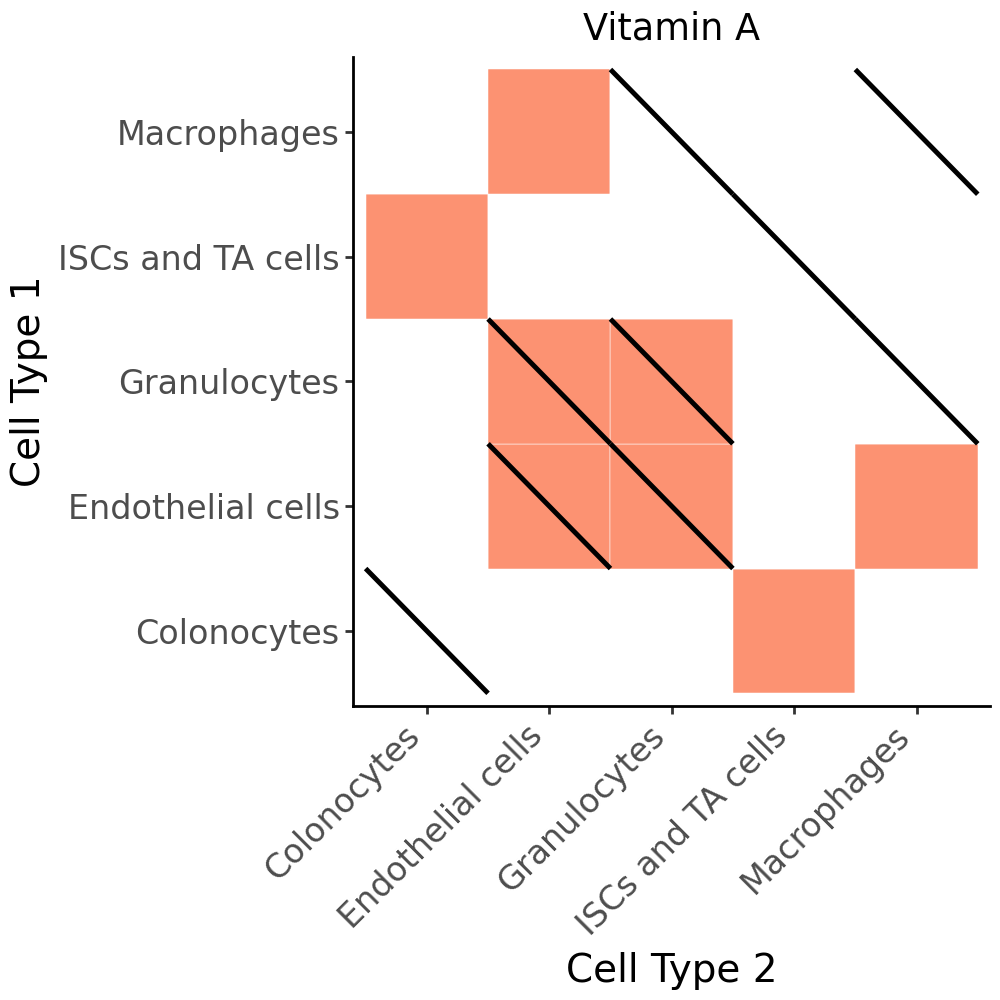

In [102]:
cell_com_df_m_sig_full_metab_gp = cell_com_df_m_sig_full_gp[cell_com_df_m_sig_full_gp['metabolite'] == 'Vitamin A'].copy()
cell_com_df_m_sig_full_metab = cell_com_df_m_sig_full[cell_com_df_m_sig_full['metabolite'] == 'Vitamin A'].copy()

diag_lines = cell_com_df_m_sig_full_metab_gp[cell_com_df_m_sig_full_metab_gp['selected']].copy()

# For plotting diagonal lines, define tile corners
diag_lines['x'] = diag_lines['Cell Type 2']
diag_lines['y'] = diag_lines['Cell Type 1']
diag_lines['xend'] = diag_lines['Cell Type 2']
diag_lines['yend'] = diag_lines['Cell Type 1']

# Map to numeric (for line coordinates)
val_sum = 0.5
x_order = {k: i+1 for i, k in enumerate(cell_types)}
diag_lines['x0'] = diag_lines['x'].map(x_order) - val_sum
diag_lines['x1'] = diag_lines['x'].map(x_order) + val_sum
diag_lines['y0'] = diag_lines['y'].map(x_order) - val_sum
diag_lines['y1'] = diag_lines['y'].map(x_order) + val_sum

p = (
    ggplot(cell_com_df_m_sig_full_metab, aes(x='Cell Type 2', y='Cell Type 1')) +
    # Base tiles
    geom_tile(aes(fill='selected'), color='white', show_legend=False) +
    scale_fill_manual(values={True: '#FC9272', False: 'white'}) +

    # Diagonal lines for second condition
    geom_segment(
        diag_lines,
        aes(x='x1', y='y0', xend='x0', yend='y1'),
        color='black',
        size=1
    ) +

    # Aesthetics
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, ha='right', size=12),
            axis_text_y=element_text(size=12),
            axis_title_x=element_text(size=14),
            axis_title_y=element_text(size=14),
            figure_size=(5, 5)) +
    labs(x='Cell Type 2', y='Cell Type 1', fill='-log10(FDR)', title='Vitamin A')
)
p

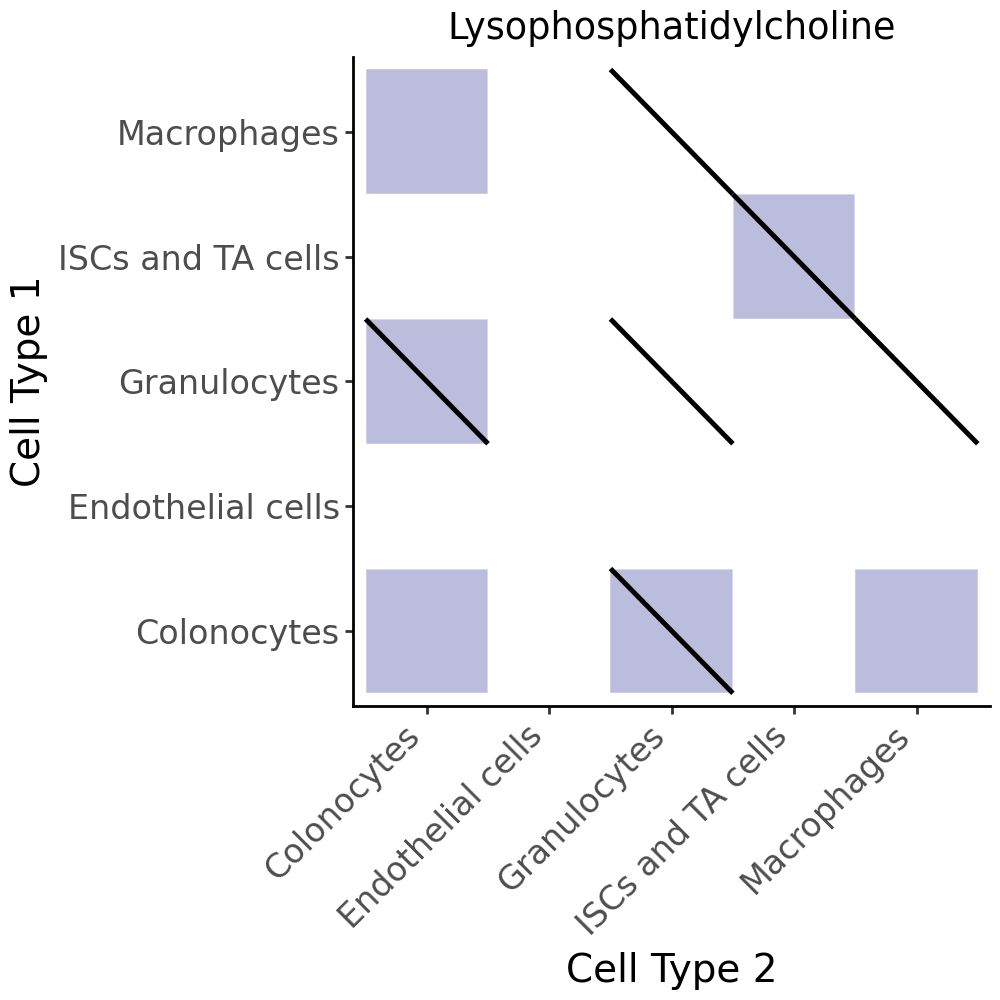

In [103]:
cell_com_df_m_sig_full_metab_gp = cell_com_df_m_sig_full_gp[cell_com_df_m_sig_full_gp['metabolite'] == 'Lysophosphatidylcholine'].copy()
cell_com_df_m_sig_full_metab = cell_com_df_m_sig_full[cell_com_df_m_sig_full['metabolite'] == 'Lysophosphatidylcholine'].copy()

diag_lines = cell_com_df_m_sig_full_metab_gp[cell_com_df_m_sig_full_metab_gp['selected']].copy()

# For plotting diagonal lines, define tile corners
diag_lines['x'] = diag_lines['Cell Type 2']
diag_lines['y'] = diag_lines['Cell Type 1']
diag_lines['xend'] = diag_lines['Cell Type 2']
diag_lines['yend'] = diag_lines['Cell Type 1']

# Map to numeric (for line coordinates)
val_sum = 0.5
x_order = {k: i+1 for i, k in enumerate(cell_types)}
diag_lines['x0'] = diag_lines['x'].map(x_order) - val_sum
diag_lines['x1'] = diag_lines['x'].map(x_order) + val_sum
diag_lines['y0'] = diag_lines['y'].map(x_order) - val_sum
diag_lines['y1'] = diag_lines['y'].map(x_order) + val_sum

p = (
    ggplot(cell_com_df_m_sig_full_metab, aes(x='Cell Type 2', y='Cell Type 1')) +
    # Base tiles
    geom_tile(aes(fill='selected'), color='white', show_legend=False) +
    scale_fill_manual(values={True: '#BCBDDC', False: 'white'}) +

    # Diagonal lines for second condition
    geom_segment(
        diag_lines,
        aes(x='x1', y='y0', xend='x0', yend='y1'),
        color='black',
        size=1
    ) +

    # Aesthetics
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, ha='right', size=12),
            axis_text_y=element_text(size=12),
            axis_title_x=element_text(size=14),
            axis_title_y=element_text(size=14),
            figure_size=(5, 5)) +
    labs(x='Cell Type 2', y='Cell Type 1', fill='-log10(FDR)', title='Lysophosphatidylcholine')
)
p

### Cell-type-specific interacting cell scores

Finally, we visualize the cell-type-specific interacting cell scores with the `plot_ct_interacting_cell_scores` function. For this, we can select the metabolites or gene pairs of interest through the `interactions` parameter and the cell types of interest through the `cell_type_pair` parameter. The latter accepts either a list of cell types (which visualizes every pair a given cell type is part of) or a list of cell type pairs (tuples), where we only visualize the interacting scores corresponding to the specified cell type pairs.

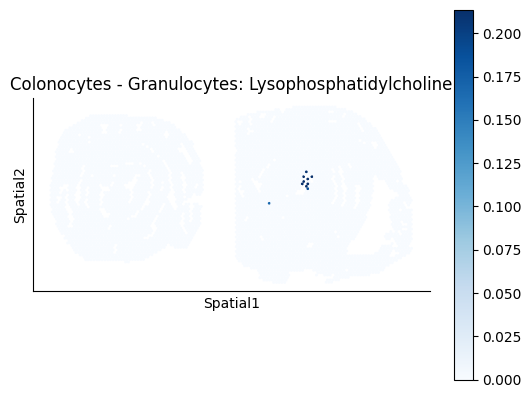

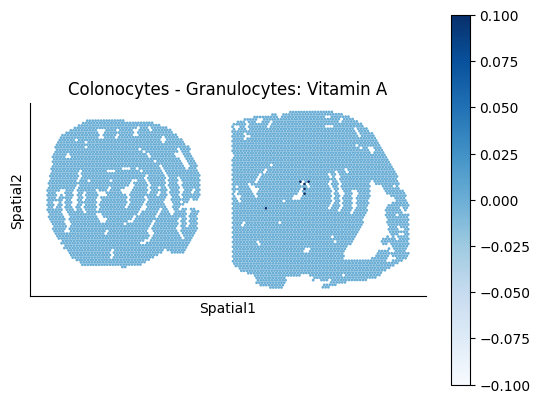

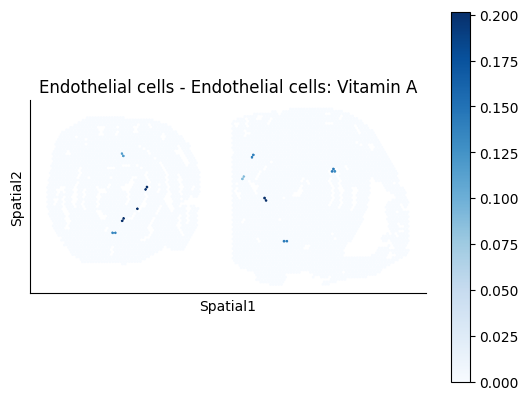

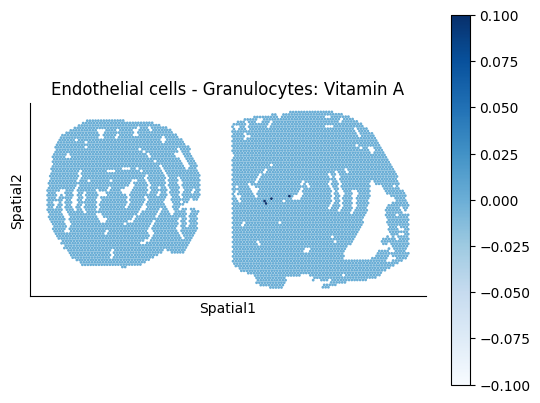

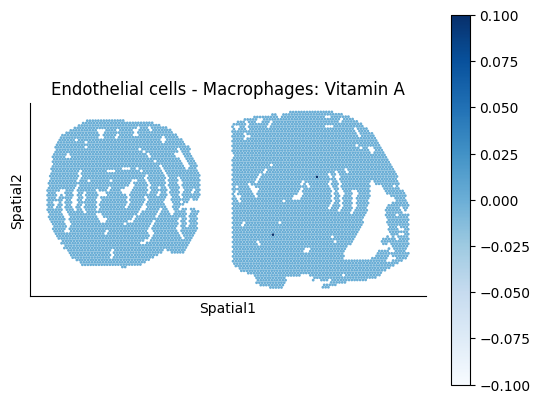

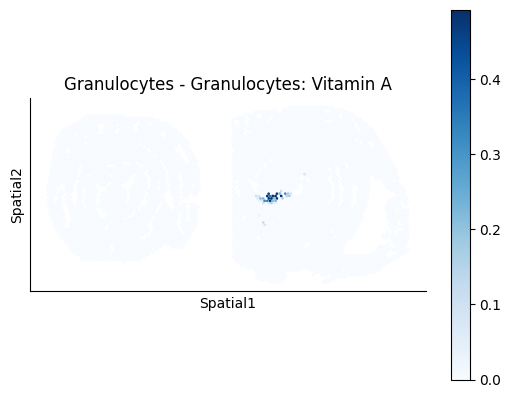

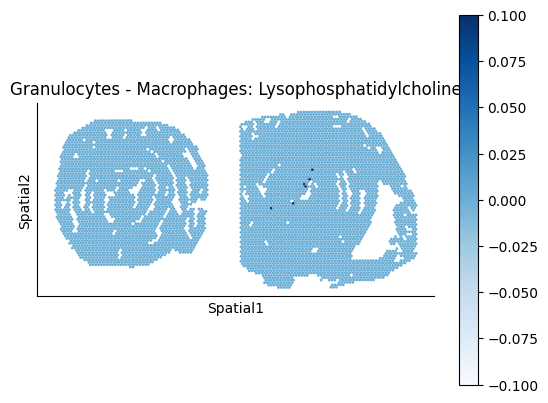

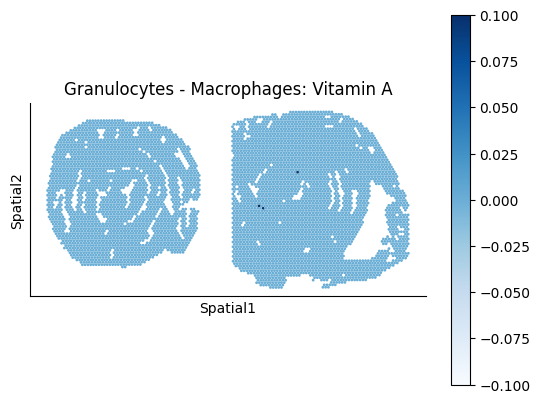

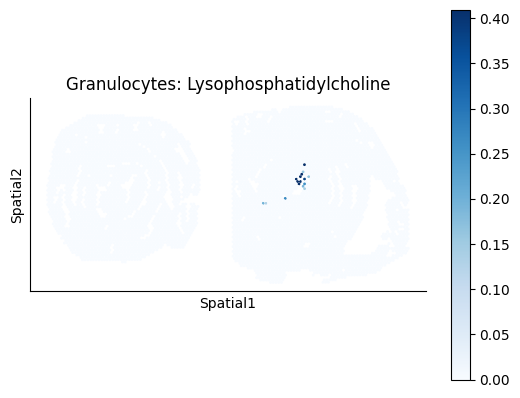

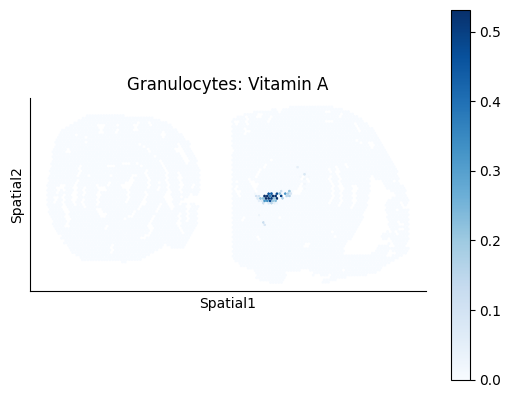

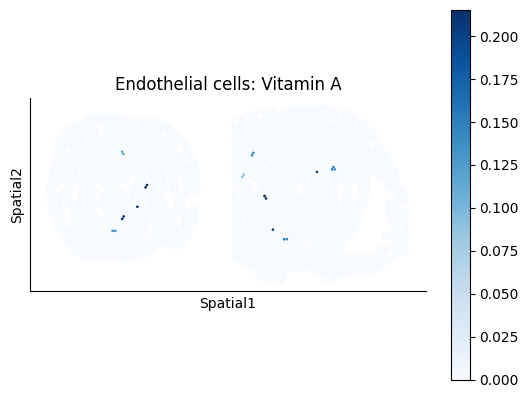

In [104]:
harreman.pl.plot_ct_interacting_cell_scores(adata, interactions=['Vitamin A', 'Lysophosphatidylcholine'], cell_type_pair=['Granulocytes', 'Endothelial cells'], test='non-parametric', coords_obsm_key='spatial', s=1, vmin=0, vmax='p99.9', normalize_values=True, cmap='Blues', swap_y_axis=True)

We can also visualize the scores on top of the H&E images.

In [106]:
d0_adata = harreman.datasets.load_visium_mouse_colon_dataset(sample='d0')
d14_adata = harreman.datasets.load_visium_mouse_colon_dataset(sample='d14')

100%|██████████| 399M/399M [00:11<00:00, 35.7MB/s] 
100%|██████████| 495M/495M [00:17<00:00, 29.4MB/s] 


In [108]:
interacting_cell_scores_m = adata.obsm['ct_interacting_cell_results_np_m_cs_df']
interactions = ['Lysophosphatidylcholine', 'Vitamin A']
ct_pairs = ['Granulocytes']

def match_columns(df, ct_pairs, interactions):
    matched_columns = []
    per_cell_aggregation = {}
    for col in df.columns:
        ct_pair_str, interaction = col.split(': ', 1)
        if interaction not in interactions:
            continue
        if not ct_pairs:
            matched_columns.append(col)
            continue
        try:
            ct1, ct2 = ct_pair_str.split(' - ')
        except ValueError:
            continue  # skip malformed cell type pairs

        for query in ct_pairs:
            if ' - ' in query:
                # Exact match of cell type pair
                if query == f"{ct1} - {ct2}":
                    matched_columns.append(col)
                    break
            else:
                # Single cell type: match if in either position
                if query == ct1 or query == ct2:
                    matched_columns.append(col)
                    key = f"{query}: {interaction}"
                    if key not in per_cell_aggregation:
                        per_cell_aggregation[key] = df[col].copy()
                    else:
                        per_cell_aggregation[key] += df[col]
                    break

    selected_df = df[matched_columns]
    if per_cell_aggregation:
        agg_df = pd.concat(per_cell_aggregation, axis=1)
    else:
        agg_df = pd.DataFrame(index=df.index)  # empty fallback

    return selected_df, agg_df

m_selected, scores = match_columns(interacting_cell_scores_m, ct_pairs, interactions)
scores = scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [109]:
cmap=sns.color_palette(["#08519C", "#FEE08B", "#EF3B2C"])
custom_cmap = ListedColormap(cmap)

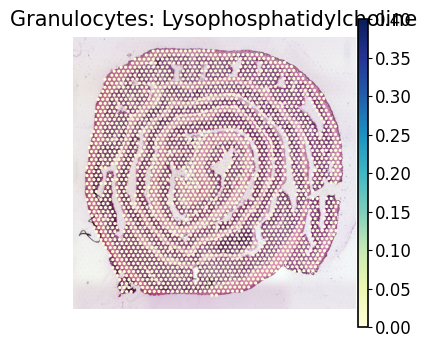

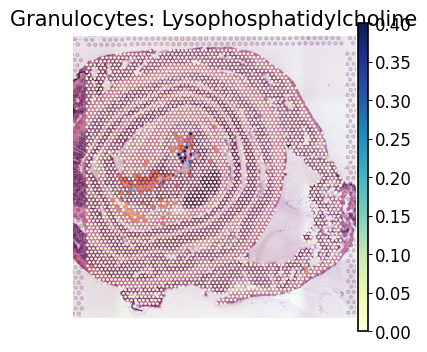

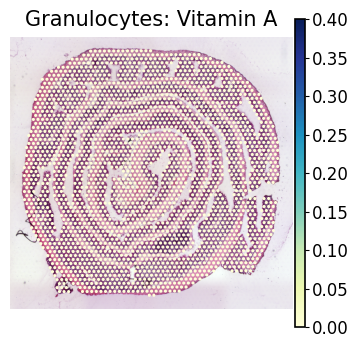

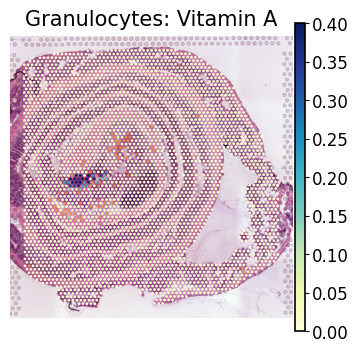

In [110]:
for interaction in scores.columns:
    p99 = np.percentile(scores[interaction], 99.9)
    p1 = np.percentile(scores[interaction], 1)
    for ad_ in [d0_adata, d14_adata]:
        with mplscience.style_context():
            cond = ad_.obs['cond'].cat.categories[0]
            if interaction not in ad_.obs.columns:
                ad_.obs[interaction] = scores[interaction]
            ad_.obs[interaction] = ad_.obs[interaction].fillna(0)
            ad_.obs['cell_type'] = adata.obs['cell_type']
            mask = (ad_.obs['cell_type'] == 'Granulocytes') & (ad_.obs[interaction] == 0)
            ad_.obs.loc[mask, interaction] = np.nan
            sc.pl.spatial(ad_, color=interaction, frameon=False, spot_size=70, img_key="hires", legend_loc=None, title=interaction, show=False, vmin=0, vmax=0.4, cmap='YlGnBu', na_color='#FD8D3C')